# Real or Fake? Using Machine Learning to predict fake news
In this project we are using machine learning to determine if it can detect fake or real news. We have a dataframe that consists of variables such as xyz

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [6]:
df = pd.read_csv("fake_news_dataset.csv") #reading the dataset 

# Standardize to lowercase strings if needed
df['label'] = df['label'].map({'Real': 0, 'Fake': 1})
df['label'] = df['label'].astype(int)

In [27]:
print(df.columns)

Index(['id', 'title', 'author', 'text', 'state', 'date_published', 'source',
       'category', 'sentiment_score', 'word_count', 'char_count', 'has_images',
       'has_videos', 'readability_score', 'num_shares', 'num_comments',
       'political_bias', 'fact_check_rating', 'is_satirical', 'trust_score',
       'source_reputation', 'clickbait_score', 'plagiarism_score', 'label'],
      dtype='object')


If you look above, there is a list of variables our dataset has. Some of these are important, some of these are not. What we can do in order to remove variables that are deemed "useless" is feature selection. This will remove variables with low variance, along with removing noise and reduces overfitting. This will allow for our model to efficiently use data and help predict fake news

In [ ]:
### INSERT FEATURE SELECTION. ONCE DONE, WE CAN SHOW THE COLUMNS THAT SEEM IMPORTANT TO OUR PROJECT

In [4]:
# df = pd.read_csv("fake_news_dataset.csv") #reading the dataset 
# df = df[['id', 'state', 'date_published', 'source',                       
#        'category', 'sentiment_score', 'word_count', 'has_images',
#        'has_videos', 'readability_score', 'num_shares', 'num_comments',
#        'political_bias', 'fact_check_rating', 'is_satirical', 'trust_score',
#        'source_reputation', 'clickbait_score', 'plagiarism_score', 'label']]   #we dont want author, title, character count or text because the
#                                                                                #information is irrelevant, so we remove it

# df.dropna #we drop all NA values

# df['True'] = df['label'].replace({'Fake':0, 'Real': 1}) #we make a new column called "True" and changing the string "Fake" to 0 and "Real" to 1.

# # df['label'] = df['label'].map({'Real': 0, 'Fake': 1})
# # df['label'] = df['label'].astype(int)

# df = df[['id', 'state', 'date_published', 'source',
#        'category', 'sentiment_score', 'word_count', 'has_images',
#        'has_videos', 'readability_score', 'num_shares', 'num_comments',
#        'political_bias', 'fact_check_rating', 'is_satirical', 'trust_score',
#        'source_reputation', 'clickbait_score', 'plagiarism_score', 'True']]   #we do the same thing, we just remove  'label'

# # # Standardize to lowercase strings if needed


  
# df.head(4)  #print out the first four samples

Now that we have filtered out the useless variables, we can start answering questions.

The first question we want to solve is: <b>1) Which state might be populated with the most fake news ?</b> <br>
we want to do this by filtering fake news, along with states that they are located in

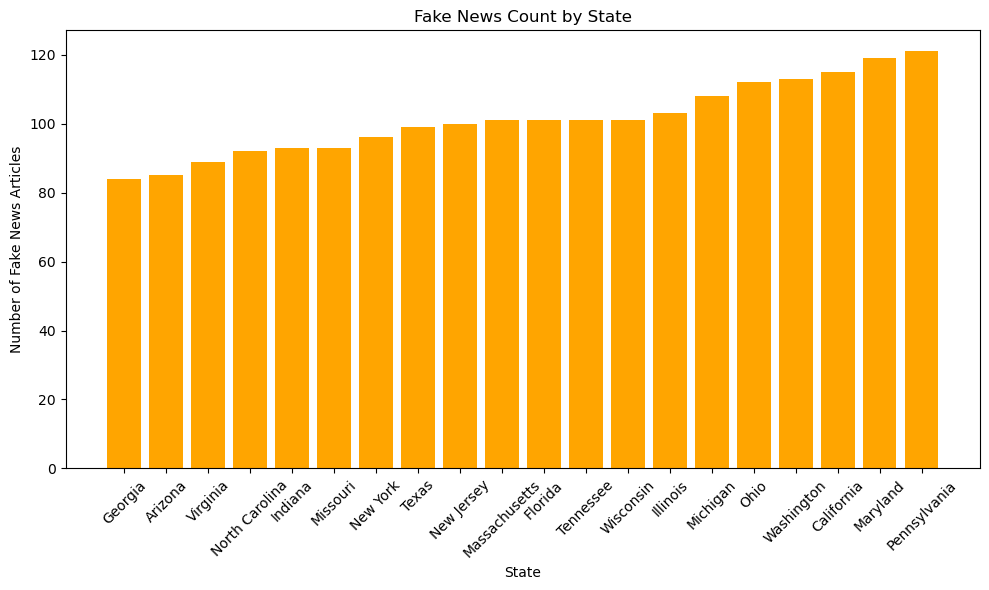

In [31]:
# Filter dataset to include only fake news (label == 1)
fake_news_df = df[df['label'] == 1]

# Group by each state and count the number of fake news articles per state
fake_news_by_state = fake_news_df.groupby('state').size().reset_index(name='fake_news_count')

fake_news_by_state = fake_news_by_state.sort_values(by='fake_news_count', ascending=True)


# Display the result
# print(fake_news_by_state)

plt.figure(figsize=(10, 6))
plt.bar(fake_news_by_state['state'], fake_news_by_state['fake_news_count'], color='orange')
plt.xticks(rotation=45)
plt.xlabel('State')
plt.ylabel('Number of Fake News Articles')
plt.title('Fake News Count by State')
plt.tight_layout()
plt.show()

As you can see, Florida has the most fake news in this dataset, as we organize from lowest to highest. We want to answer other questions that are more interesting, and could lead us into finding something new to find out. The next cell, we want to use machine learning to help find fake or real news, so we will do some testing

In [8]:
# Make a copy to avoid modifying the original DataFrame
df_encoded = df.copy()

# --- One-hot encode 'has_images' and 'has_videos'
df_encoded = pd.get_dummies(df_encoded, columns=['has_images', 'has_videos'], drop_first=True)

# --- Label encode 'state', 'source', and 'category'
le_state = LabelEncoder()
le_source = LabelEncoder()
le_category = LabelEncoder()

df_encoded['state'] = le_state.fit_transform(df_encoded['state'])        
df_encoded['source_encoded'] = le_source.fit_transform(df_encoded['source'])
df_encoded['category_encoded'] = le_category.fit_transform(df_encoded['category'])
df_encoded['political_bias_encoded'] = le_category.fit_transform(df_encoded['political_bias'])

# Optional: drop original text columns if no longer needed
df_encoded = df_encoded.drop(columns=['source', 'category'])

# # Check the result
# print(df_encoded.head())


In [9]:
features = [
    'state',
    'source_encoded',
    'category_encoded',
    'sentiment_score',
    'word_count',
    #'char_count',
    'has_images_1',
    'has_videos_1',
    'readability_score',
    'num_shares',
    'num_comments',
    'political_bias_encoded',
    'is_satirical',
    'trust_score',
    'source_reputation',
    #'clickbait_score',
    #'plagiarism_score'
]                                   #we choose features that would potentially give us the best results

X = df_encoded[features]
y = df_encoded['label'] 

# ---------------------------------------------------


# Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#temp set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



# ---------------------------------------------------

#validation 

# Define classifiers and their hyperparameters
models = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'model__C': [0.01, 0.1, 1, 10]
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'model__max_depth': [3, 5, 10, None],
            'model__min_samples_split': [2, 5, 10]
        }
    },
    'SVM': {
        'model': SVC(),
        'params': {
            'model__C': [0.1, 1, 10],
            'model__kernel': ['linear', 'rbf']
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'model__n_neighbors': [3, 5, 7, 9]
        }
    }
}

# Store results
results = []

# Iterate over classifiers
for name, clf in models.items():
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', clf['model'])
    ])
    
    grid = GridSearchCV(pipe, clf['params'], cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_val)
    
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    results.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })
    
    print(f"\n{name} — Best Parameters: {grid.best_params_}")
    print(classification_report(y_val, y_pred, digits=3))

# Create a summary table
results_df = pd.DataFrame(results)
print("\nModel Performance Summary:\n")
print(results_df.sort_values(by="F1-Score", ascending=False))



Logistic Regression — Best Parameters: {'model__C': 0.01}
              precision    recall  f1-score   support

           0      0.464     0.402     0.431       194
           1      0.500     0.563     0.530       206

    accuracy                          0.485       400
   macro avg      0.482     0.483     0.480       400
weighted avg      0.483     0.485     0.482       400


Decision Tree — Best Parameters: {'model__max_depth': 5, 'model__min_samples_split': 2}
              precision    recall  f1-score   support

           0      0.536     0.459     0.494       194
           1      0.551     0.626     0.586       206

    accuracy                          0.545       400
   macro avg      0.544     0.542     0.540       400
weighted avg      0.544     0.545     0.542       400


SVM — Best Parameters: {'model__C': 0.1, 'model__kernel': 'rbf'}
              precision    recall  f1-score   support

           0      0.406     0.134     0.202       194
           1      0.500

If you look at the bottom here: <br>
 &nbsp;  &nbsp;    Accuracy  &nbsp; Precision    &nbsp; Recall  &nbsp; &nbsp; &nbsp; &nbsp; F1-Score  
2:     0.4850   &nbsp; &nbsp; 0.500000  &nbsp; &nbsp; 0.815534  &nbsp; &nbsp; 0.619926  
1:     0.5450   &nbsp; &nbsp; 0.551282  &nbsp; &nbsp; 0.626214 &nbsp; &nbsp;  0.586364  
0    0.4850   &nbsp; &nbsp; 0.500000  &nbsp; &nbsp; 0.563107 &nbsp; &nbsp;  0.529680  
3    0.4775   &nbsp; &nbsp; 0.491979 &nbsp; &nbsp;  0.446602  &nbsp; &nbsp; 0.468193  <br>
<br>
2: SVM <br>
1: Decision Tree <br>
0: LR <br>
3: kNN <br>
<br>
SVM has the highest f1 score, meaning it is important in both recall and precison. These two variables help determine if the model can determine the news to be "real" or "fake". Since it scores the highest in terms of a validation set, we will be using this model to help determine if it can detect real or fake news.

Here is a confusion matrix that shows more information on which model would give us more accuracy


Logistic Regression — Best Parameters: {'model__C': 0.01}
              precision    recall  f1-score   support

           0      0.464     0.402     0.431       194
           1      0.500     0.563     0.530       206

    accuracy                          0.485       400
   macro avg      0.482     0.483     0.480       400
weighted avg      0.483     0.485     0.482       400



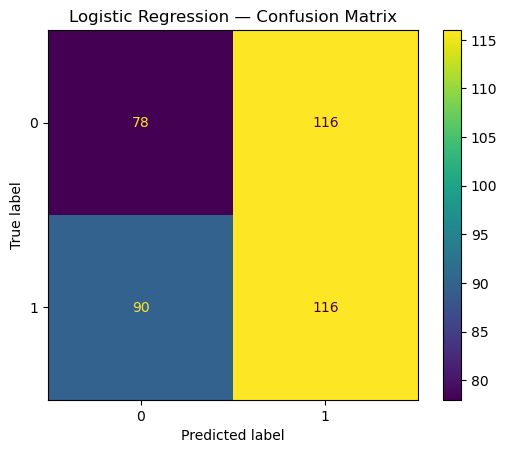


Decision Tree — Best Parameters: {'model__max_depth': 5, 'model__min_samples_split': 2}
              precision    recall  f1-score   support

           0      0.539     0.459     0.496       194
           1      0.553     0.631     0.590       206

    accuracy                          0.547       400
   macro avg      0.546     0.545     0.543       400
weighted avg      0.546     0.547     0.544       400



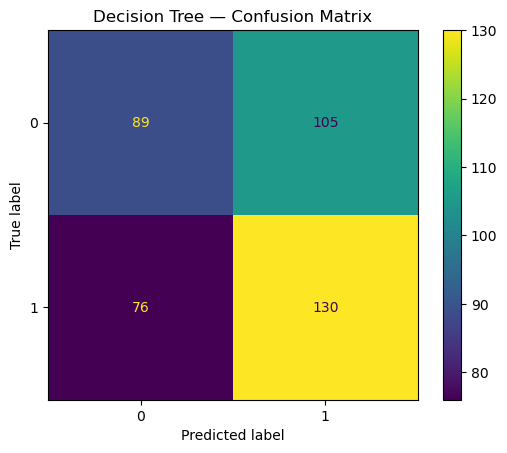


SVM — Best Parameters: {'model__C': 0.1, 'model__kernel': 'rbf'}
              precision    recall  f1-score   support

           0      0.406     0.134     0.202       194
           1      0.500     0.816     0.620       206

    accuracy                          0.485       400
   macro avg      0.453     0.475     0.411       400
weighted avg      0.455     0.485     0.417       400



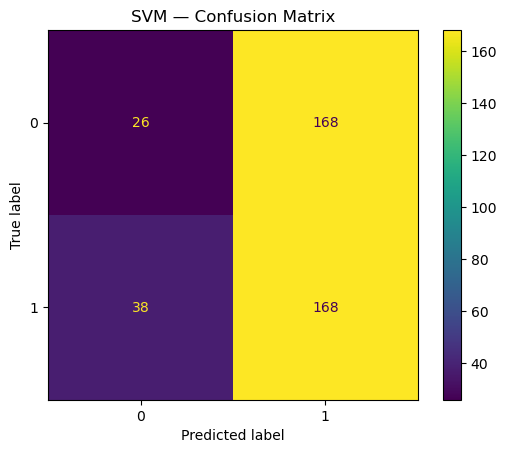


KNN — Best Parameters: {'model__n_neighbors': 5}
              precision    recall  f1-score   support

           0      0.465     0.510     0.486       194
           1      0.492     0.447     0.468       206

    accuracy                          0.477       400
   macro avg      0.478     0.478     0.477       400
weighted avg      0.479     0.477     0.477       400



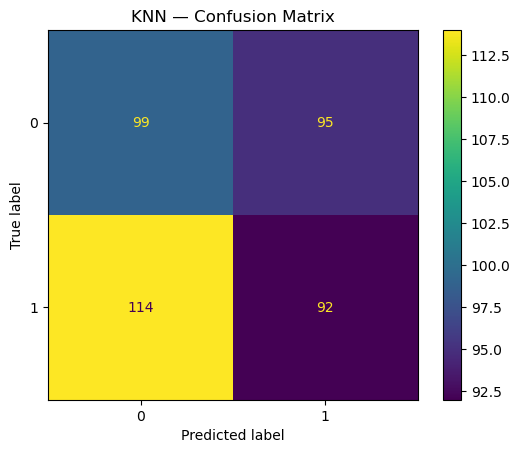


Model Performance Summary:

                 Model                                        Best Params  \
2                  SVM          {'model__C': 0.1, 'model__kernel': 'rbf'}   
6                  SVM          {'model__C': 0.1, 'model__kernel': 'rbf'}   
5        Decision Tree  {'model__max_depth': 5, 'model__min_samples_sp...   
1        Decision Tree  {'model__max_depth': 5, 'model__min_samples_sp...   
0  Logistic Regression                                 {'model__C': 0.01}   
4  Logistic Regression                                 {'model__C': 0.01}   
3                  KNN                          {'model__n_neighbors': 5}   
7                  KNN                          {'model__n_neighbors': 5}   

   Accuracy  Precision    Recall  F1-Score  
2    0.4850   0.500000  0.815534  0.619926  
6    0.4850   0.500000  0.815534  0.619926  
5    0.5475   0.553191  0.631068  0.589569  
1    0.5450   0.551282  0.626214  0.586364  
0    0.4850   0.500000  0.563107  0.529680  
4    0.

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Iterate over classifiers
for name, clf in models.items():
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', clf['model'])
    ])
    
    grid = GridSearchCV(pipe, clf['params'], cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_val)
    
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    results.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })
    
    # Print the performance metrics
    print(f"\n{name} — Best Parameters: {grid.best_params_}")
    print(classification_report(y_val, y_pred, digits=3))
    
    # Generate and display confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
    disp.plot()
    plt.title(f"{name} — Confusion Matrix")
    plt.show()

# Create a summary table
results_df = pd.DataFrame(results)
print("\nModel Performance Summary:\n")
print(results_df.sort_values(by="F1-Score", ascending=False))

- Top left: True Negative (TN) – Correctly predicted "fake news" (0) as fake news.<br>
- Top right: False Positive (FP) – Incorrectly predicted "real news" (1) when it was actually fake news (0).<br>
- Bottom left: False Negative (FN) – Incorrectly predicted "fake news" (0) when it was actually real news (1).<br>
- Bottom right: True Positive (TP) – Correctly predicted "real news" (1) as real news.<br>


<br>
<br>
SVM still has the highest f1 score, so we will stick with SVM. We can test our model with "new" data using train_test_split in order to help determine if the model can determine if the news is fake or not.

Classification Report (New Test Set):
              precision    recall  f1-score   support

           0      0.530     0.579     0.554       290
           1      0.569     0.519     0.543       310

    accuracy                          0.548       600
   macro avg      0.549     0.549     0.548       600
weighted avg      0.550     0.548     0.548       600



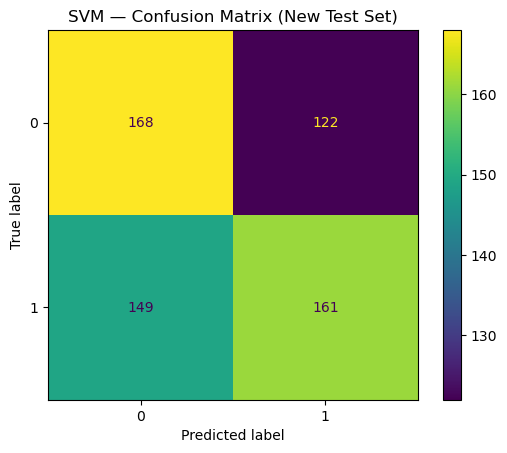

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# First split to create a new test set from the original dataset
X_train, X_unused, y_train, y_unused = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% for training

# Split the unused subset into validation and new test set
X_val, X_new, y_val, y_new = train_test_split(X_unused, y_unused, test_size=0.5, random_state=42)

# SVM is already trained on X_train, y_train 
# testing the  model on the "new" data:
y_pred_new = best_model.predict(X_new)

# Evaluate on new test set
print("Classification Report (New Test Set):")
print(classification_report(y_new, y_pred_new, digits=3))

# Generate and display confusion matrix for new testing information
cm_new = confusion_matrix(y_new, y_pred_new)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_new, display_labels=best_model.classes_)
disp.plot()
plt.title("SVM — Confusion Matrix (New Test Set)")
plt.show()